In [1]:
from ft_engineering import ft_engineering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import(
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import seaborn as sns
df = ft_engineering()
# Lista de las métricas que queremos visualizar
metrics_to_plot = ["accuracy", "precision", "recall", "f1_score", "roc_auc","casosNoTomaLicor"]
scoring_metrics = ["accuracy", "f1", 'precision', "recall"]

In [2]:
def summarize_classification(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred, normalize=True)
    prec = precision_score(y_test, y_pred,pos_label=0)
    recall = recall_score(y_test, y_pred,pos_label=0)
    f1 = f1_score(y_test, y_pred,pos_label=0)
    roc = roc_auc_score(y_test, y_pred)
    cantidadNoTomaLicor = np.count_nonzero(y_pred == 0)

    

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc,
        "casosNoTomaLicor": cantidadNoTomaLicor
    }

In [3]:
def build_model(
    classifier_fn,
    data_params: dict,
    test_frac: float = 0.2,
) -> dict:
    """
    Function to train a classification model

    Args:
        classifier_fn: classification function
        preprocessor (ColumnTransformer): preprocessor pipeline object
        data_params (dict): dictionary containing 'name_of_y_col',
                            'names_of_x_cols', and 'dataset'
        test_frac (float): fraction of data for the test, default 0.2

    Returns:
        dict: dictionary with the model performance metrics on train and test

    """

    # Extract data parameters
    name_of_y_col = data_params["name_of_y_col"]
    names_of_x_cols = data_params["names_of_x_cols"]
    dataset = data_params["dataset"]

    # Separate the feature columns and the target column
    X = dataset[names_of_x_cols]
    Y = dataset[name_of_y_col]

    # Split the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_frac, random_state=1234
    )

    # Create the pipeline with preprocessing and the classification model
    classifier_pipe = Pipeline(
        steps=[("model", classifier_fn)]
    )

    # Train the classifier pipeline
    model = classifier_pipe.fit(x_train, y_train)

    # Predict the test data
    y_pred = model.predict(x_test)

    # Predict the train data
    y_pred_train = model.predict(x_train)

    # Calculate the performance metrics
    train_summary = summarize_classification(y_train, y_pred_train)
    test_summary = summarize_classification(y_test, y_pred)

    kfold = KFold(n_splits=10)
    model_pipe = Pipeline(steps=[("model", model)])

    cv_results = {}
    train_results = {}

    # Ejecutamos validación cruzada
    for metric in scoring_metrics[:-1]:  
        cv_results[metric] = cross_val_score(
            model_pipe, x_train, y_train, cv=kfold, scoring=metric
        )
        # Se evalúa sobre el Dataset de pruebas
        model_pipe.fit(x_train, y_train)
        train_results[metric] = model_pipe.score(x_train, y_train)

    # Se convierten los resultados en un df
    cv_results_df = pd.DataFrame(cv_results)

    common_params = {
        "X": x_train,
        "y": y_train,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
        "n_jobs": -1,
        "return_times": True,
    }

    scoring_metric = "recall"

    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        model_pipe, **common_params, scoring=scoring_metric
    )

    # Calculate the mean and standard deviation of the scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Calculate the mean and standard deviation of the fit and score times
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    # Plot the learning curve
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
    ax.plot(train_sizes, train_mean, "o-", label="Training score")
    ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
    ax.fill_between(
        train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
    )

    # Configure the title and labels
    ax.set_title(f"Learning Curve for {model.steps[-1][1].__class__.__name__}")
    ax.set_xlabel("Training examples")
    ax.set_ylabel(scoring_metric)
    ax.legend(loc="best")

    # Show the plot
    plt.show()

    # Print the values for analysis
    print("Training Sizes:", train_sizes)
    print("Training Scores Mean:", train_mean)
    print("Training Scores Std:", train_std)
    print("Test Scores Mean:", test_mean)
    print("Test Scores Std:", test_std)

        # Plot the scalability regarding fit time and score time
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

    # Scalability regarding the fit time
    ax[0].plot(train_sizes, fit_times_mean, "o-")
    ax[0].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.3,
    )
    ax[0].set_ylabel("Fit time (s)")
    ax[0].set_title(f"Scalability of the {model.steps[-1][1].__class__.__name__} classifier")

    # Scalability regarding the score time
    ax[1].plot(train_sizes, score_times_mean, "o-")
    ax[1].fill_between(
        train_sizes,
        score_times_mean - score_times_std,
        score_times_mean + score_times_std,
        alpha=0.3,
    )
    ax[1].set_ylabel("Score time (s)")
    ax[1].set_xlabel("Number of training samples")

    # Show the plot
    plt.show()

    # Print the fit and score times for analysis
    print("Fit Times Mean:", fit_times_mean)
    print("Fit Times Std:", fit_times_std)
    print("Score Times Mean:", score_times_mean)
    print("Score Times Std:", score_times_std)

    return {"train": train_summary, "test": test_summary}

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [5]:
y = 'consume_licor'
features = df.columns[df.columns != y].tolist()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29890 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   bin_encoder__ocio                                29890 non-null  float64
 1   bin_encoder__membresia_premium                   29890 non-null  float64
 2   poly_ohe__genero_Masculino                       29890 non-null  float64
 3   poly_ohe__ciudad_residencia_Chicago              29890 non-null  float64
 4   poly_ohe__ciudad_residencia_Dallas               29890 non-null  float64
 5   poly_ohe__ciudad_residencia_Denver               29890 non-null  float64
 6   poly_ohe__ciudad_residencia_Houston              29890 non-null  float64
 7   poly_ohe__ciudad_residencia_Miami                29890 non-null  float64
 8   poly_ohe__ciudad_residencia_NYC                  29890 non-null  float64
 9   poly_ohe__ciudad_residencia_Phoen

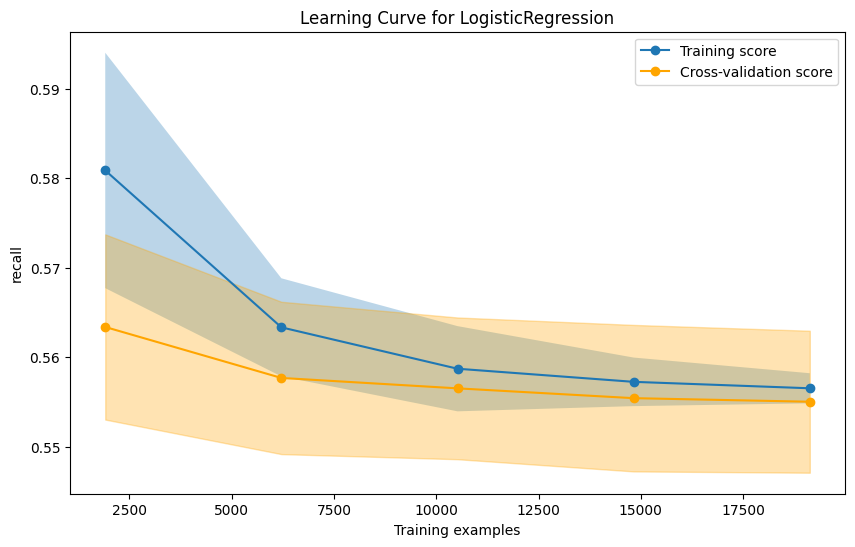

Training Sizes: [ 1912  6216 10520 14824 19129]
Training Scores Mean: [0.58085933 0.56334491 0.55872611 0.55726264 0.55654373]
Training Scores Std: [0.01313783 0.00547571 0.0047549  0.00271005 0.00168073]
Test Scores Mean: [0.56338366 0.55769676 0.55653534 0.55544016 0.55504225]
Test Scores Std: [0.01033311 0.00850069 0.00790885 0.00817521 0.00792368]


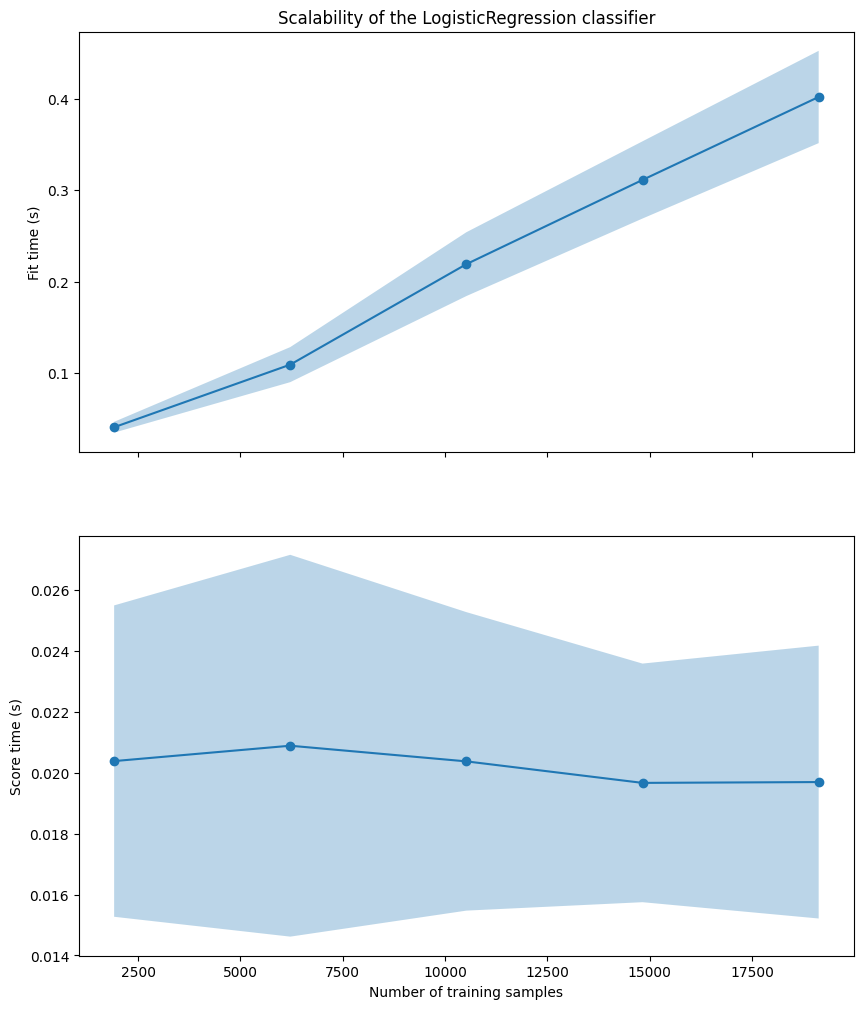

Fit Times Mean: [0.04049219 0.1090488  0.2190885  0.31132397 0.4021828 ]
Fit Times Std: [0.00591843 0.01919242 0.03495157 0.0422829  0.05054408]
Score Times Mean: [0.02038646 0.02089145 0.02037718 0.01967028 0.01969747]
Score Times Std: [0.00511514 0.0062727  0.0049038  0.00391995 0.00448301]


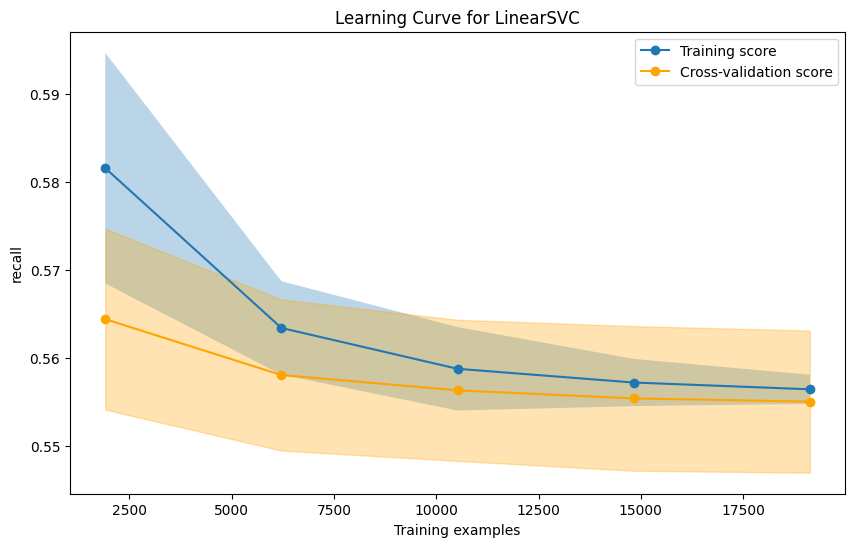

Training Sizes: [ 1912  6216 10520 14824 19129]
Training Scores Mean: [0.58158709 0.56342872 0.55878744 0.55722763 0.55645712]
Training Scores Std: [0.013106   0.00531209 0.00473833 0.00268186 0.00165432]
Test Scores Mean: [0.56442446 0.55808023 0.5563388  0.55542185 0.55505535]
Test Scores Std: [0.01028292 0.00858378 0.00801674 0.00821312 0.00807481]


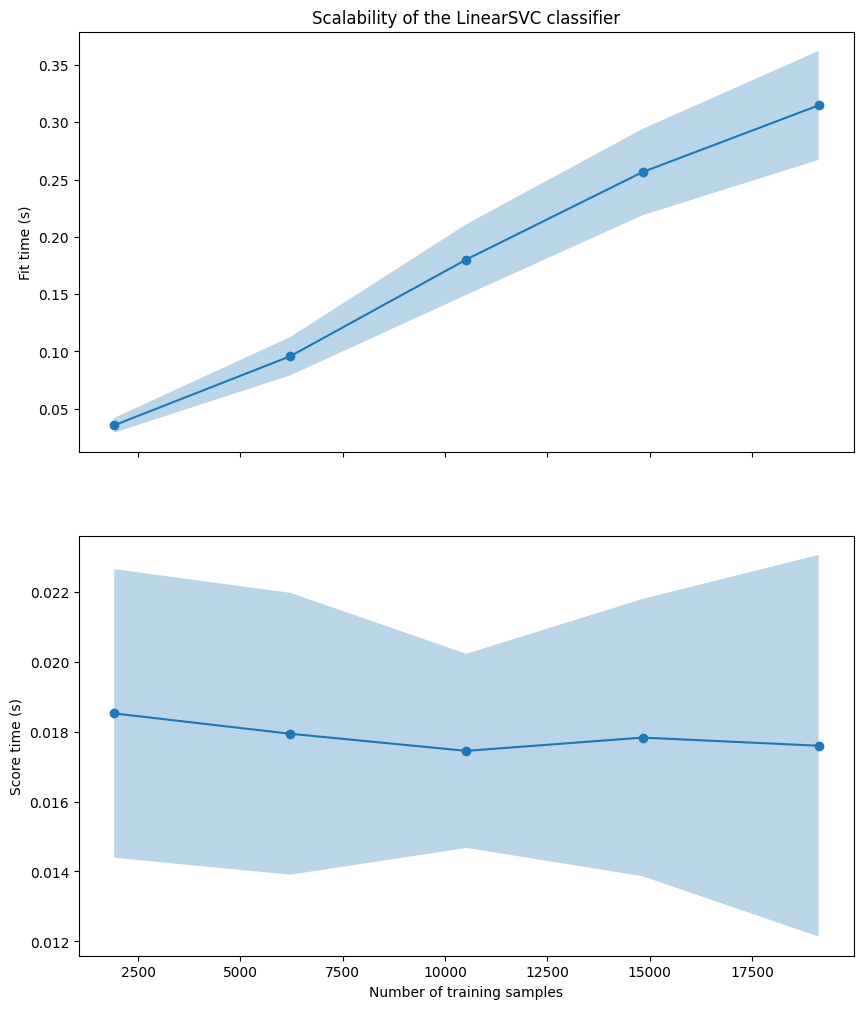

Fit Times Mean: [0.03553109 0.09578471 0.18021496 0.25652082 0.31479057]
Fit Times Std: [0.0064291  0.01675168 0.03084537 0.03771861 0.04759652]
Score Times Mean: [0.01852002 0.01793857 0.01744938 0.01782863 0.01759646]
Score Times Std: [0.00412721 0.00403108 0.00277708 0.00396458 0.00545994]


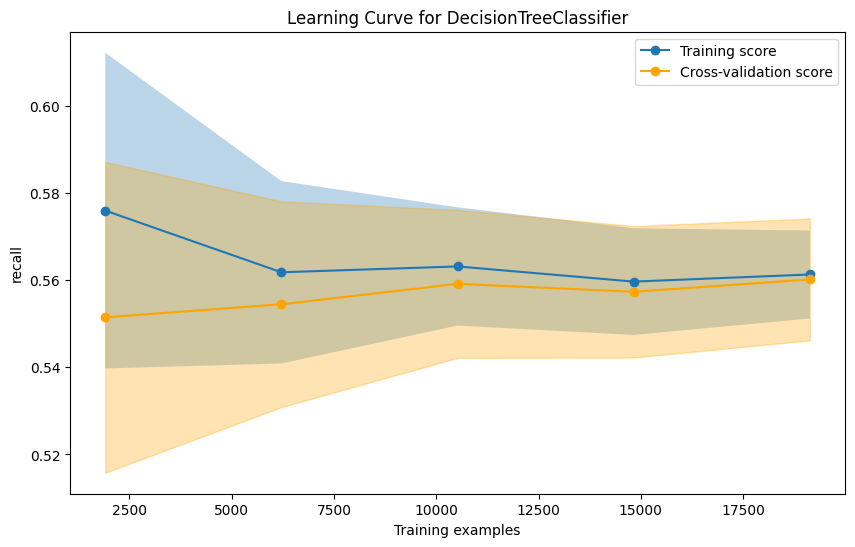

Training Sizes: [ 1912  6216 10520 14824 19129]
Training Scores Mean: [0.57591405 0.56176878 0.56311122 0.55963604 0.56126193]
Training Scores Std: [0.03618538 0.02090199 0.01354953 0.01222802 0.01008289]
Test Scores Mean: [0.55144084 0.55443841 0.55911768 0.55729791 0.56012836]
Test Scores Std: [0.03561855 0.02358022 0.01697153 0.01506481 0.01396117]


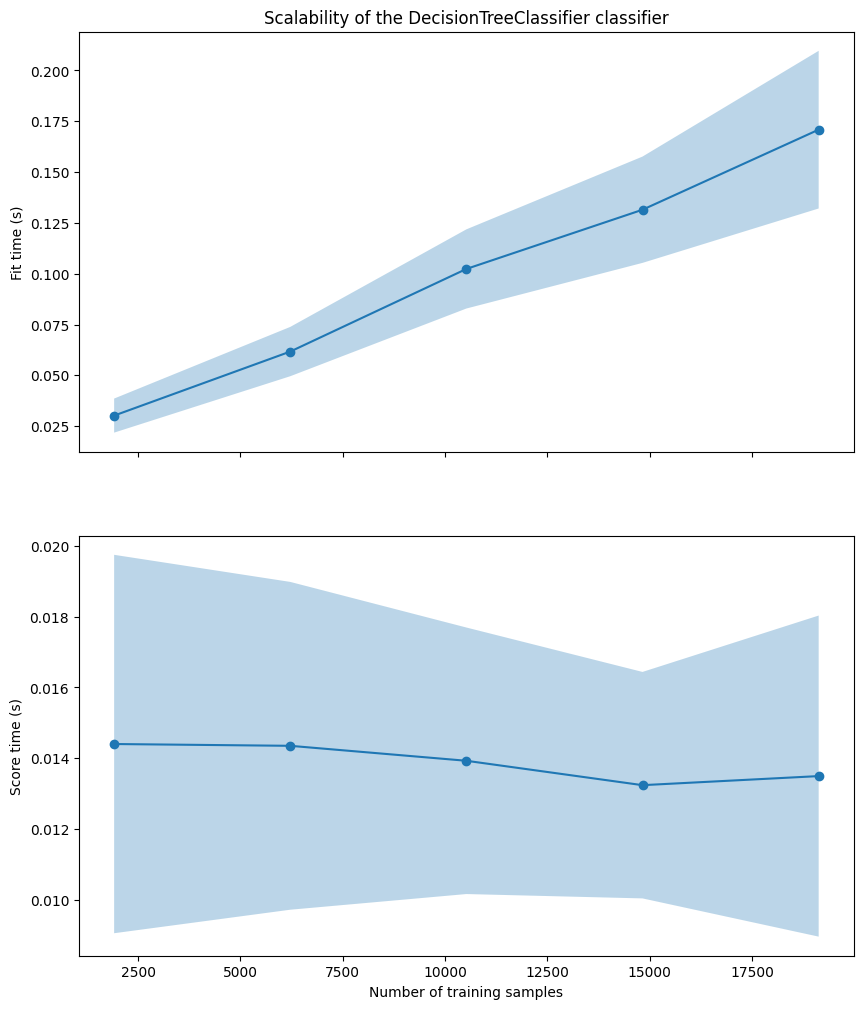

Fit Times Mean: [0.0302013  0.06170409 0.10235693 0.13148704 0.17088978]
Fit Times Std: [0.00837884 0.01213387 0.01947556 0.02615169 0.03878692]
Score Times Mean: [0.01440371 0.01435307 0.01393048 0.0132418  0.01349809]
Score Times Std: [0.00534296 0.00462857 0.00376326 0.00319759 0.00453344]


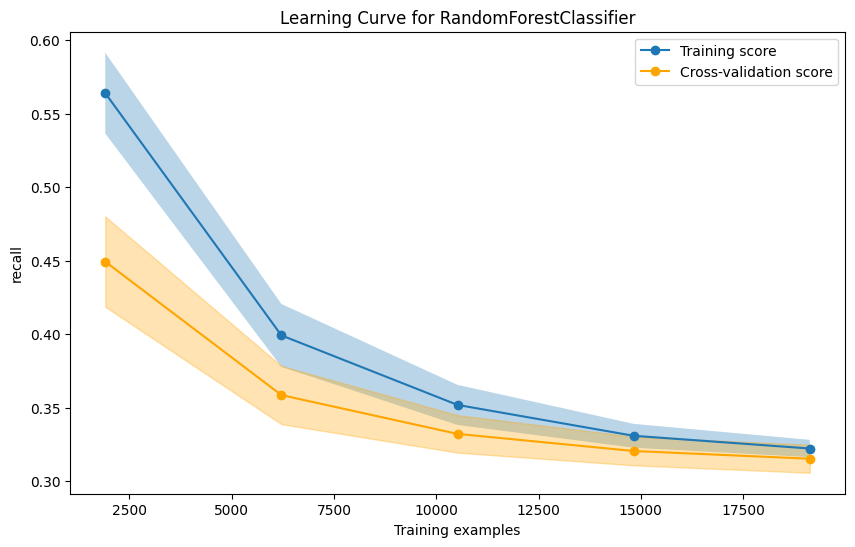

Training Sizes: [ 1912  6216 10520 14824 19129]
Training Scores Mean: [0.56398399 0.39913271 0.35181411 0.33080839 0.32214793]
Training Scores Std: [0.02749416 0.02137326 0.01365058 0.00812305 0.00588732]
Test Scores Mean: [0.44930467 0.35851321 0.33210062 0.32044312 0.31517431]
Test Scores Std: [0.03072155 0.01978103 0.01275213 0.00974519 0.00950765]


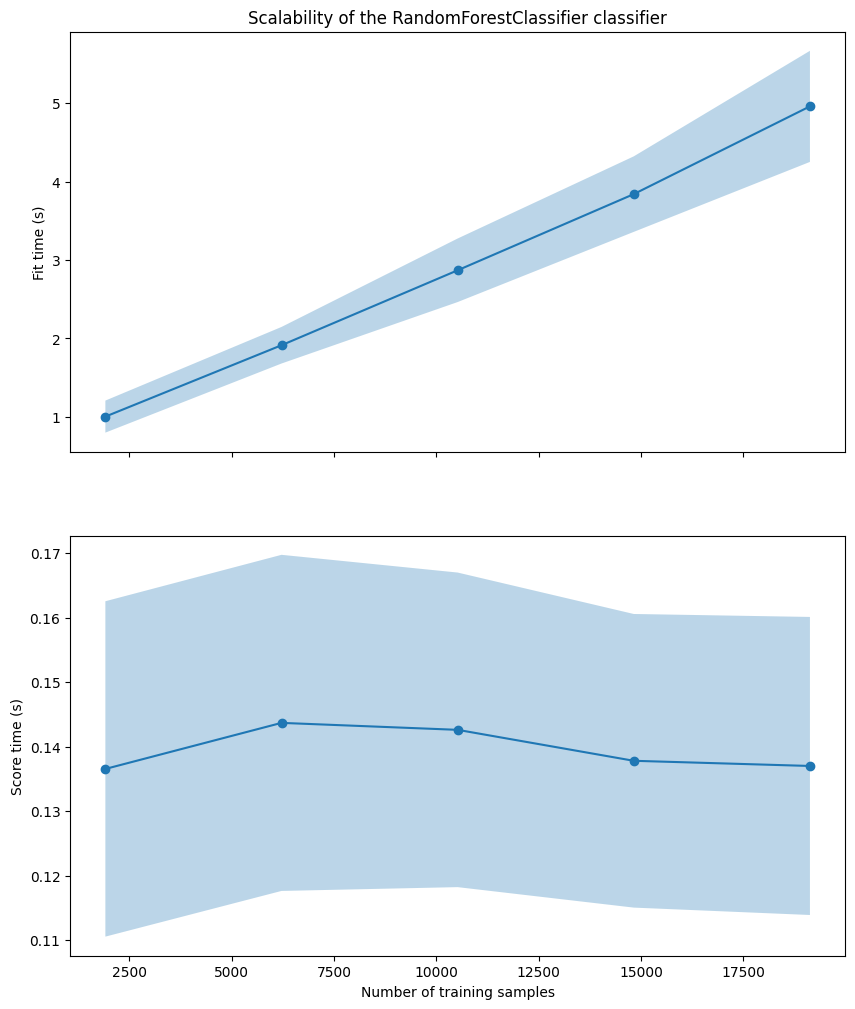

Fit Times Mean: [1.00385056 1.91353185 2.86877286 3.83955053 4.95804565]
Fit Times Std: [0.20421498 0.23308429 0.40496003 0.48135884 0.70803269]
Score Times Mean: [0.13653624 0.1436784  0.14259894 0.13779898 0.13699722]
Score Times Std: [0.02600327 0.02606021 0.0243902  0.02276499 0.02310932]


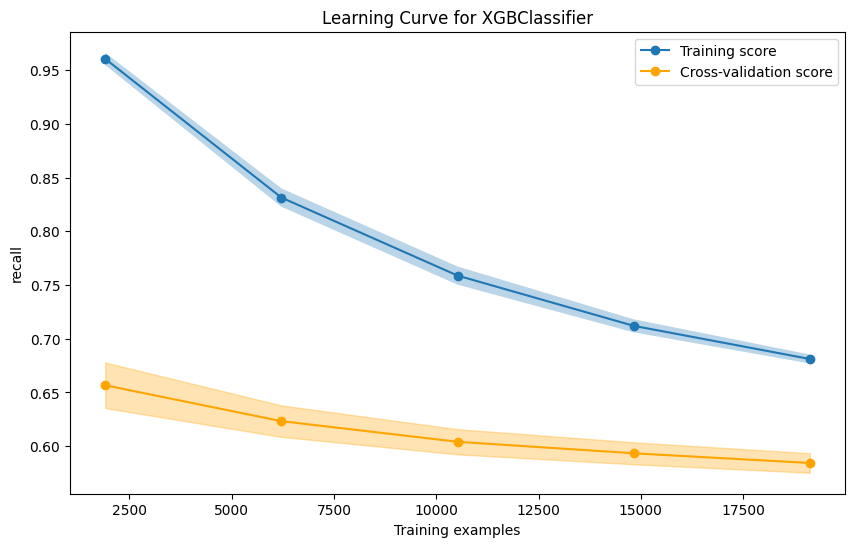

Training Sizes: [ 1912  6216 10520 14824 19129]
Training Scores Mean: [0.96045069 0.83135701 0.75876575 0.7119952  0.68112265]
Training Scores Std: [0.00570919 0.0085426  0.00847515 0.00607452 0.00418285]
Test Scores Mean: [0.65664557 0.62326545 0.60408004 0.59336261 0.58433602]
Test Scores Std: [0.0211907  0.01465217 0.01172231 0.01023903 0.0090654 ]


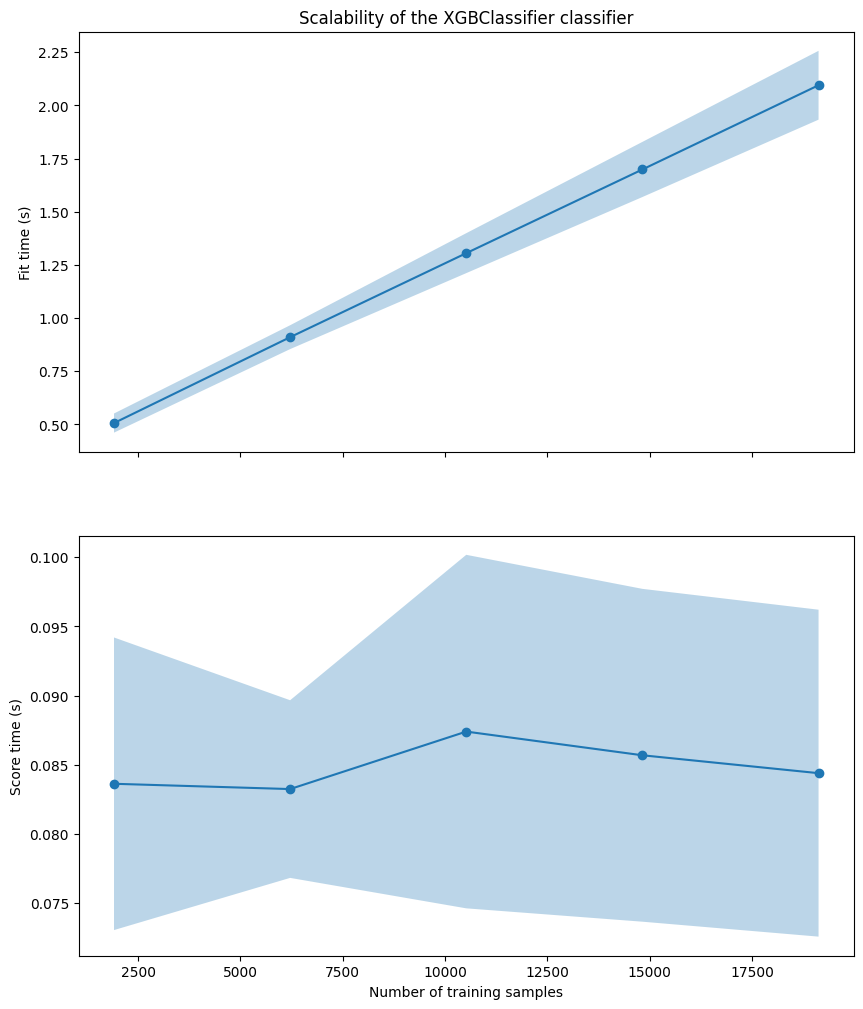

Fit Times Mean: [0.50625427 0.91019877 1.3053224  1.69888515 2.09504947]
Fit Times Std: [0.04496378 0.05611901 0.09394467 0.1296566  0.16190638]
Score Times Mean: [0.08362669 0.08324413 0.08740106 0.08568764 0.08439381]
Score Times Std: [0.01057913 0.00642329 0.01278235 0.0120343  0.01182054]


In [7]:
result_dict = {}
models = {
    "logistic": LogisticRegression(solver="liblinear",class_weight='balanced'),
    # class_weight='balanced' para manejar clases desbalanceadas
    "svc": LinearSVC(C=1.0, max_iter=1000, tol=1e-3, dual=False,class_weight='balanced'),
    "decision_tree": DecisionTreeClassifier(max_depth=5,min_samples_leaf=10,class_weight='balanced'),
    "random_forest": RandomForestClassifier(class_weight='balanced',n_estimators=150,max_depth=7,min_samples_leaf=5,max_features='sqrt'),
    "xgboost": XGBClassifier(eval_metric='logloss',scale_pos_weight=11518 / 18484,n_estimators=200,max_depth=6,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8)
    
}

data_params = {
    "name_of_y_col": y,
    "names_of_x_cols": features,
    "dataset": df
}
for model_name, model in models.items():
    result_dict[model_name] = build_model(model, data_params)

In [8]:
records = []
for model_name, model_results in result_dict.items():
    for data_set, metrics in model_results.items():
        for metric_name, score in metrics.items():
            records.append({
                "Model": model_name,
                "Data Set": data_set,
                "Metric": metric_name,
                "Score": score
            })

results_df = pd.DataFrame(records)

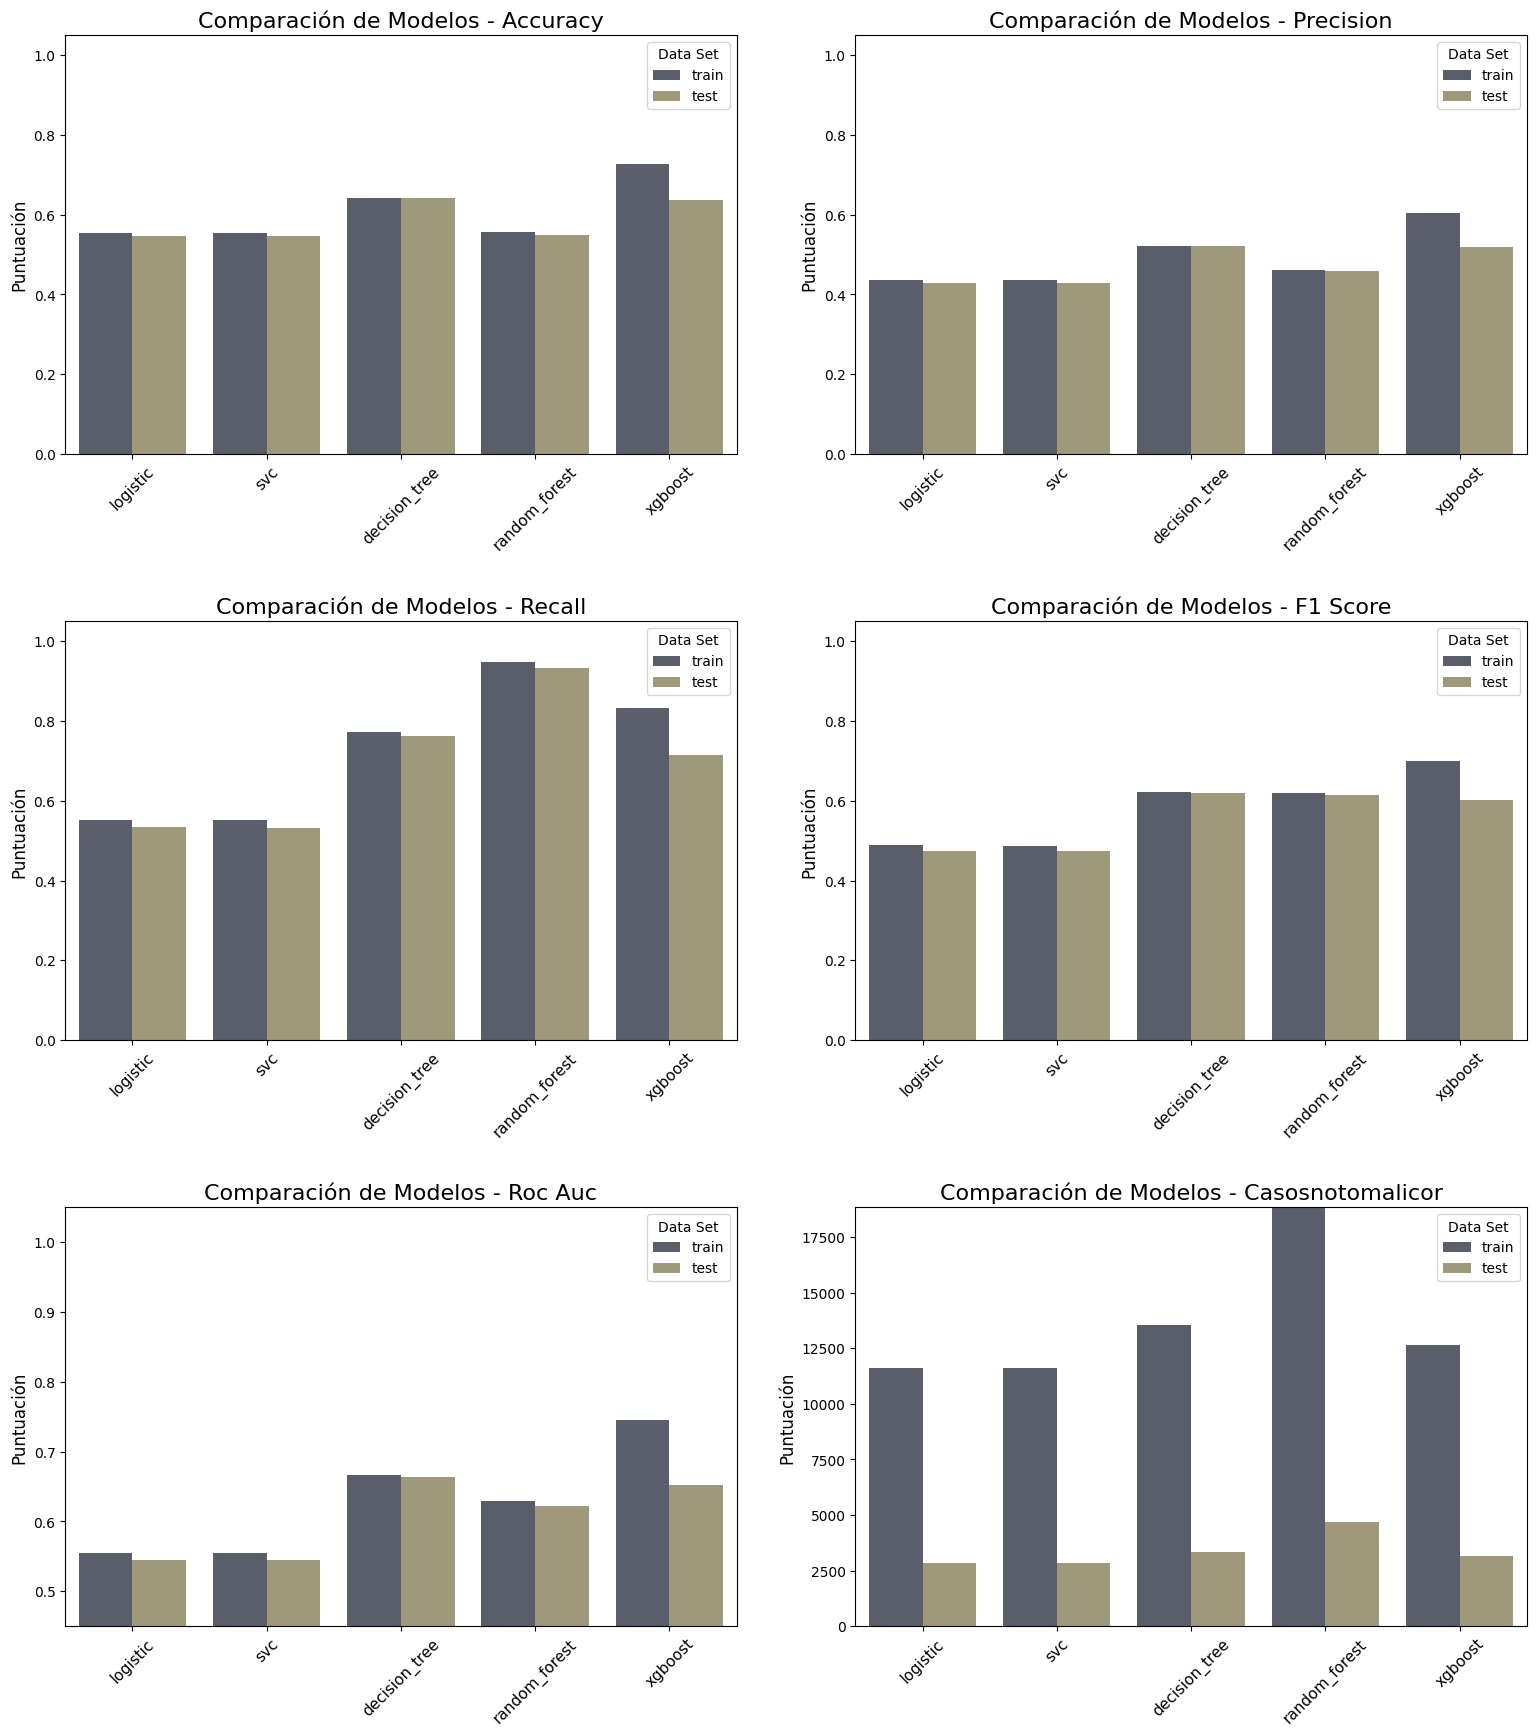

In [9]:

# Crear una figura con una cuadrícula de subplots (3 filas, 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten() # Aplanar la matriz de ejes para iterar fácilmente

# Iterar sobre cada métrica y crear un gráfico para ella
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    # Filtrar el DataFrame para la métrica actual
    metric_df = results_df[results_df["Metric"] == metric]
    
    # Crear el gráfico de barras agrupado
    sns.barplot(data=metric_df, x="Model", y="Score", hue="Data Set", ax=ax, palette="cividis")
    
    ax.set_title(f'Comparación de Modelos - {metric.replace("_", " ").title()}', fontsize=16)
    ax.set_ylabel("Puntuación", fontsize=12)
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45, labelsize=11)
    
    # Ajustar el límite del eje Y para que la comparación sea justa
    # Para ROC AUC, la escala es de 0.45 a 1.05 para ver mejor las diferencias
    if metric == 'roc_auc':
        ax.set_ylim(0.45, 1.05)
    elif metric == 'casosNoTomaLicor':
        max_no_toma = results_df[results_df["Metric"] == "casosNoTomaLicor"]["Score"].max()
        ax.set_ylim(0, max_no_toma + 5)
    else:
        ax.set_ylim(0, 1.05)

# Ocultar el último subplot que no se usa
if len(metrics_to_plot) < len(axes):
    axes[-1].set_visible(False)

# Ajustar el diseño para que no se superpongan los títulos
plt.tight_layout(pad=3.0)
plt.show()

In [10]:
print(results_df)

            Model Data Set            Metric         Score
0        logistic    train          accuracy      0.555077
1        logistic    train         precision      0.436423
2        logistic    train            recall      0.552876
3        logistic    train          f1_score      0.487795
4        logistic    train           roc_auc      0.554660
5        logistic    train  casosNoTomaLicor  11608.000000
6        logistic     test          accuracy      0.547508
7        logistic     test         precision      0.428421
8        logistic     test            recall      0.533101
9        logistic     test          f1_score      0.475063
10       logistic     test           roc_auc      0.544796
11       logistic     test  casosNoTomaLicor   2857.000000
12            svc    train          accuracy      0.554701
13            svc    train         precision      0.436063
14            svc    train            recall      0.552657
15            svc    train          f1_score      0.4874

In [11]:
df = ft_engineering()
df.columns = [x.replace('__','_') for x in df.columns]
y = 'consume_licor'
features = df.columns[df.columns != y].tolist()
X = df[features]
Y = df[y]

    # Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=1234
    )
classifier_fn = XGBClassifier(eval_metric='logloss',scale_pos_weight=11518 / 18484,n_estimators=200,max_depth=6,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8)
model = classifier_fn.fit(x_train, y_train)

    # Predict the test data
y_pred = model.predict(x_test)

    # Predict the train data
y_pred_train = model.predict(x_train)
model.save_model('xgb_model.json')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29890 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   bin_encoder_ocio                                29890 non-null  float64
 1   bin_encoder_membresia_premium                   29890 non-null  float64
 2   poly_ohe_genero_Masculino                       29890 non-null  float64
 3   poly_ohe_ciudad_residencia_Chicago              29890 non-null  float64
 4   poly_ohe_ciudad_residencia_Dallas               29890 non-null  float64
 5   poly_ohe_ciudad_residencia_Denver               29890 non-null  float64
 6   poly_ohe_ciudad_residencia_Houston              29890 non-null  float64
 7   poly_ohe_ciudad_residencia_Miami                29890 non-null  float64
 8   poly_ohe_ciudad_residencia_NYC                  29890 non-null  float64
 9   poly_ohe_ciudad_residencia_Phoenix          